# Bayesian Mixture Model

A Bayesian mixture model arises when we cannot condition on which component generated each observation, so we treat component memberships as latent variables and integrate over both memberships and component parameters to quantify uncertainty about the underlying mixture structure in the data.

# Graphical Summary

![Fig](./graphical_summary/slides/Slide29.png)

# Key Formula

In a Bayesian mixture model, we cannot observe which component generated each observation, so we model this uncertainty by assuming the parameters come from a weighted combination of different distributions:

$$
p(\beta) = \sum_{c=1}^{C} \pi_c p_c(\beta)
$$

where:
- $\pi_c$ represents the probability that component $c$ generated the parameters (mixing weights with $\sum_{c=1}^{C} \pi_c = 1$)
- $p_c(\beta)$ is the prior distribution for parameters under component $c$
- $C$ is the number of components in the mixture

This captures heterogeneity by allowing the parameters to arise from different models, while quantifying our uncertainty about which subpopulation they belong to.

# Technical Details

In statistical genetics, we cannot condition on which type each genetic effect represents -- null, moderate, or large. Bayesian mixture models explicitly quantify this uncertainty by treating parameters as arising from multiple possible distributions.

## Component Assignment and Latent Variables

Since we cannot observe which component generated each parameter $\beta$, we introduce a latent variable $Z \in \{1, 2, \ldots, C\}$ representing unknown membership:

$$
P(Z = c) = \pi_c, \quad \beta \mid Z = c \sim p_c(\beta)
$$

where $\pi_c$ are mixing weights satisfying $\sum_{c=1}^C \pi_c = 1$.

**Marginalizing over uncertainty**: Since $Z$ is unobserved, the prior for $\beta$ integrates over all possible components:

$$
p(\beta) = \sum_{c=1}^{C} \pi_c p_c(\beta)
$$

This mixture prior captures our uncertainty about which component generated the parameter.

## Prior Specification

**Mixing weights**: For simplicity, we can use equal weights $\pi_c = 1/C$ (expressing no prior preference), though in practice $\boldsymbol{\pi}$ can be estimated from data.

For example, in the genetic effect framework, each component can represent a different effect type:
- Component 1 (null): $p_1(\beta) = \mathcal{N}(0, \sigma_1^2)$ with small $\sigma_1^2$
- Component 2 (moderate): $p_2(\beta) = \mathcal{N}(0, \sigma_2^2)$ with moderate $\sigma_2^2$  
- Component 3 (large): $p_3(\beta) = \mathcal{N}(0, \sigma_3^2)$ with large $\sigma_3^2$

Components can differ in means, variances, or both, and can even use different distribution families.


## Posterior Inference

After observing data, Bayes' rule updates our uncertainty about component membership:

$$
P(Z = c \mid \beta, \text{data}) \propto \pi_c p_c(\beta \mid \text{data})
$$

This posterior probability quantifies remaining uncertainty about which component generated each parameter. Parameters consistent with component $c$ receive higher posterior probability for that component.



## Key Advantages

**Robust estimation**: Mixture models prevent outliers from distorting estimates by assigning them to appropriate tail components.

**Automatic regularization**: Parameters are "shrunk" toward their component means, with the degree of shrinkage learned from data.

**Flexible modeling**: The mixture structure adapts to heterogeneity in effect sizes, population structure, or measurement contexts.

# Related Topics

- [ordinary least squares](https://statfungen.github.io/statgen-primer/ordinary_least_squares.html)
- [summary statistics](https://statfungen.github.io/statgen-primer/summary_statistics.html)
- [random effect](https://statfungen.github.io/statgen-primer/random_effect.html)
- [proportion of variance explained and heritability](https://statfungen.github.io/statgen-primer/proportion_of_variance_explained.html)
- [likelihood](https://statfungen.github.io/statgen-primer/likelihood.html)
- [maximum likelihood estimation](https://statfungen.github.io/statgen-primer/maximum_likelihood_estimation.html)
- [Bayesian normal mean model](https://statfungen.github.io/statgen-primer/Bayesian_normal_mean_model.html#)
- [Bayesian multivariate normal mean model](https://statfungen.github.io/statgen-primer/Bayesian_multivariate_normal_mean_model.html#)

# Example

Recall our [Lecture: Bayesian model comparison](https://statfungen.github.io/statgen-primer/Bayesian_model_comparison.html) where we compare different models for the genetic effects on height and weight of a single genetic variant.

**What about analyzing hundreds or thousands of variants simultaneously?**

In reality, genetic variants follow different biological mechanisms that we cannot condition on:

- Most variants have null effects on both traits
- Some affect only height (growth pathways)
- Others affect only weight (metabolism)  
- A few affect both traits with varying correlations

Since we cannot condition on which mechanism generated each variant, we observe only a heterogeneous scatter of effects with no clear pattern -- a mixture of all models!

Bayesian mixture models address this by treating variant effects as arising from multiple unobserved components. Rather than assuming all variants follow the same model, we ask: "What mixture of different mechanisms best explains our data?"

## Setup

We generate data for multiple genetic variants from the same list of models as in [Lecture: Bayesian model comparison](https://statfungen.github.io/statgen-primer/Bayesian_model_comparison.html):

- $\text{M}_0$ (No effect): $\boldsymbol{\beta} = (0, 0)$
- $\text{M}_1$ (Height Only): $\beta_2 = 0$
- $\text{M}_2$ (Weight Only): $\beta_1 = 0$
- $\text{M}_3$ (Perfect Correlation): $\text{cor}(\beta_1, \beta_2) = 1$
- $\text{M}_4$ (Weak Correlation): $\text{cor}(\beta_1, \beta_2) = 0.1$
- $\text{M}_5$ (Medium Correlation): $\text{cor}(\beta_1, \beta_2) = 0.5$
- $\text{M}_6$ (Strong Correlation): $\text{cor}(\beta_1, \beta_2) = 0.8$

The seven models above can actually be clustered into two groups -- no pleiotropy vs pleiotropy:

1. **No Pleiotropy Model**: Mixture of $\text{M}_0$, $\text{M}_1$, $\text{M}_2$ (null or single-trait effects)
2. **Pleiotropy Model**: Mixture of $\text{M}_3$, $\text{M}_4$, $\text{M}_5$, $\text{M}_6$ (correlated effects on both traits)

For each model, we assess detection performance and weight estimation accuracy.

In [28]:
rm(list = ls())
library(MASS)
library(mvtnorm)
library(ggplot2)
set.seed(91)

In [29]:
# Define parameters and component models
M <- 1000  # Number of genetic variants
N <- 1000 # Number of individuals

# Effect size parameters - use larger effects for better detection
effect_variance <- 1.0 

# Define the 7 models as covariance matrices
models <- list(
  M0 = matrix(c(0, 0, 
                0, 0), 
              nrow = 2, ncol = 2),
  
  M1 = matrix(c(effect_variance, 0, 
                0, 0), 
              nrow = 2, ncol = 2),
  
  M2 = matrix(c(0, 0, 
                0, effect_variance), 
              nrow = 2, ncol = 2),
  
  M3 = matrix(c(effect_variance, effect_variance,
                effect_variance, effect_variance), 
              nrow = 2, ncol = 2),
  
  M4 = matrix(c(effect_variance, 0.1 * effect_variance,
                0.1 * effect_variance, effect_variance), 
              nrow = 2, ncol = 2),
  
  M5 = matrix(c(effect_variance, 0.5 * effect_variance,
                0.5 * effect_variance, effect_variance), 
              nrow = 2, ncol = 2),
  
  M6 = matrix(c(effect_variance, 0.8 * effect_variance,
                0.8 * effect_variance, effect_variance), 
              nrow = 2, ncol = 2)
)

# Initialize models dataframe
models_df <- data.frame(
  Model = names(models),
  stringsAsFactors = FALSE
)

Among all the variants being generated, we assign 40% of them comes from $\text{M}_0$, 10% from $\text{M}_1$, etc.

In [30]:
# Generate effect sizes from mixture distribution
mixture_weights <- c(0.40, 0.10, 0.10, 0.01, 0.19, 0.15, 0.05)
names(mixture_weights) <- names(models)

# Add mixture proportions to models_df
models_df$Mixture_Prop <- mixture_weights

# Randomly assign each variant to a component
set.seed(42)
component_assignments <- sample(names(models), size = M, replace = TRUE, 
                                prob = mixture_weights)

# Generate bivariate effect sizes based on component assignment
beta_height <- numeric(M)
beta_weight <- numeric(M)

for (i in 1:M) {
  model_name <- component_assignments[i]
  cov_matrix <- models[[model_name]]
  
  if (model_name == "M0") {
    beta_height[i] <- 0
    beta_weight[i] <- 0
  } else {
    cov_matrix_reg <- cov_matrix + diag(1e-8, 2)
    effects <- mvrnorm(1, mu = c(0, 0), Sigma = cov_matrix_reg)
    beta_height[i] <- effects[1]
    beta_weight[i] <- effects[2]
  }
}

In [31]:
# Summary statistics
null_variants <- sum(component_assignments == "M0")
nonpleiotropic_variants <- sum(component_assignments %in% c("M0", "M1", "M2"))
pleiotropic_variants <- sum(component_assignments %in% c("M3", "M4", "M5", "M6"))
component_counts <- table(component_assignments)

cat("\nGenerated effect sizes for", M, "variants:\n")
component_counts
models_df


Generated effect sizes for 1000 variants:


component_assignments
 M0  M1  M2  M3  M4  M5  M6 
421  99  98   7 198 128  49 

Model,Mixture_Prop
<chr>,<dbl>
M0,0.40
M1,0.10
M2,0.10
M3,0.01
M4,0.19
M5,0.15
M6,0.05


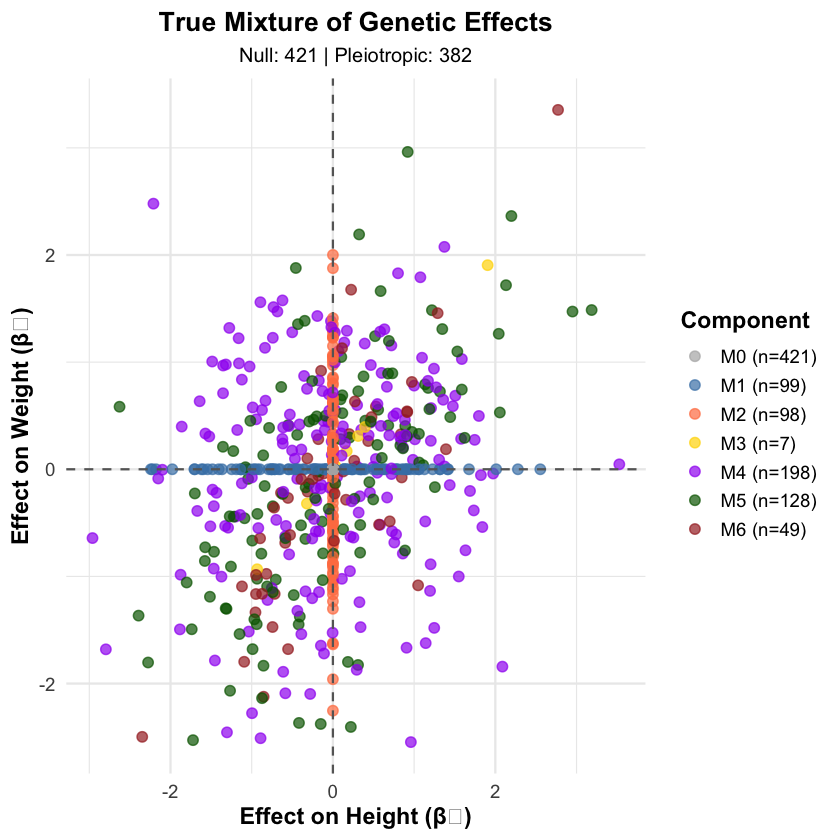

In [32]:
# Visualize the mixture of effect sizes
component_colors <- c("M0" = "gray70", "M1" = "steelblue", "M2" = "coral", 
                     "M3" = "gold", "M4" = "purple", "M5" = "darkgreen", "M6" = "brown")

plot_data <- data.frame(
  Height_Effect = beta_height,
  Weight_Effect = beta_weight,
  Component = component_assignments
)

p1 <- ggplot(plot_data, aes(x = Height_Effect, y = Weight_Effect, color = Component)) +
  geom_point(size = 2.5, alpha = 0.7) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "gray40") +
  geom_vline(xintercept = 0, linetype = "dashed", color = "gray40") +
  scale_color_manual(values = component_colors,
                     labels = paste0(names(component_counts), " (n=", component_counts, ")")) +
  labs(
    title = "True Mixture of Genetic Effects",
    subtitle = paste("Null:", null_variants, "| Pleiotropic:", pleiotropic_variants),
    x = "Effect on Height (β₁)",
    y = "Effect on Weight (β₂)"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 16),
    plot.subtitle = element_text(hjust = 0.5, size = 12),
    axis.title = element_text(face = "bold"),
    legend.title = element_text(face = "bold"),
    legend.position = "right"
  )

print(p1)

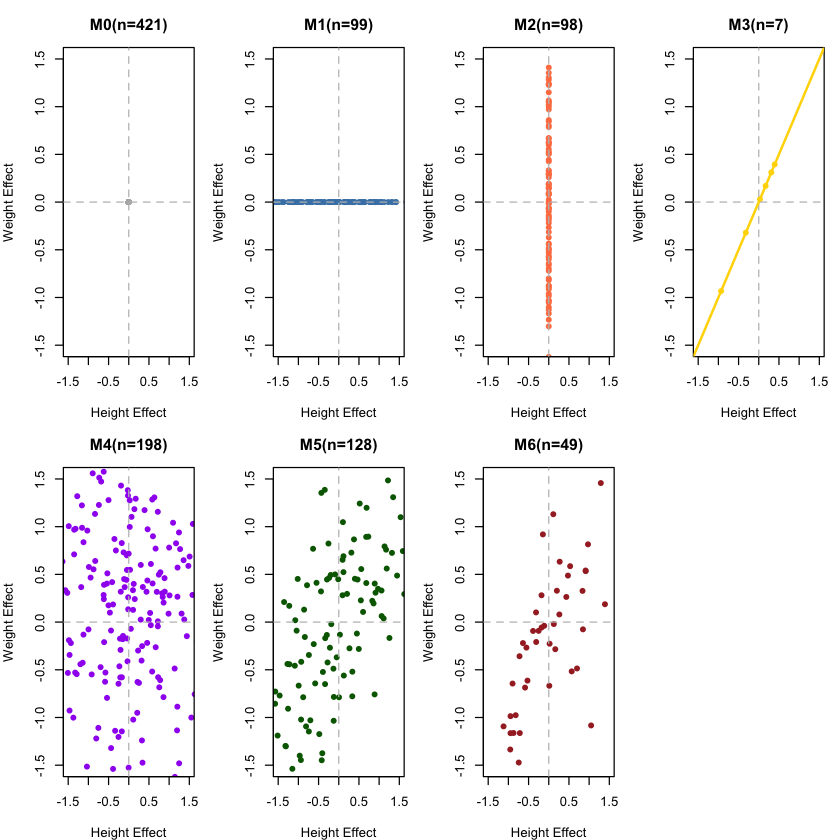

In [33]:
# Visualize each component separately to see their distinct patterns
par(mfrow = c(2, 4), mar = c(4, 4, 3, 1))

for (comp in names(models)) {
  idx <- which(component_assignments == comp)
  
  if (length(idx) > 0) {
    h_effects <- beta_height[idx]
    w_effects <- beta_weight[idx]
    
    plot(h_effects, w_effects, 
         main = paste(comp, "(n=", length(idx), ")", sep=""),
         xlab = "Height Effect", ylab = "Weight Effect",
         col = component_colors[comp], pch = 16, 
         xlim = c(-1.5, 1.5), ylim = c(-1.5, 1.5))
    abline(h = 0, v = 0, lty = 2, col = "gray")
    
    # Add correlation line for M3 (perfect correlation)
    if (comp == "M3") abline(0, 1, col = component_colors[comp], lwd = 2)
  } else {
    plot(0, 0, type = "n", xlim = c(-1.5, 1.5), ylim = c(-1.5, 1.5),
         main = paste(comp, "(n=0)", sep=""),
         xlab = "Height Effect", ylab = "Weight Effect")
    abline(h = 0, v = 0, lty = 2, col = "gray")
  }
}

par(mfrow = c(1, 1))

In [34]:
# Generate genotype and phenotype data
maf <- 0.3
X <- matrix(rbinom(N * M, size = 2, prob = maf), nrow = N, ncol = M)

# Calculate genetic values
genetic_height <- as.vector(X %*% beta_height)
genetic_weight <- as.vector(X %*% beta_weight)

# Use lower heritability to add more noise, making the problem more realistic
h2 <- 0.5  # 50% heritability

var_genetic_height <- var(genetic_height)
var_genetic_weight <- var(genetic_weight)

var_error_height <- var_genetic_height * (1 - h2) / h2
var_error_weight <- var_genetic_weight * (1 - h2) / h2

error_height <- rnorm(N, mean = 0, sd = sqrt(var_error_height))
error_weight <- rnorm(N, mean = 0, sd = sqrt(var_error_weight))

phenotype_height <- genetic_height + error_height
phenotype_weight <- genetic_weight + error_weight

h2_height_realized <- var(genetic_height) / var(phenotype_height)
h2_weight_realized <- var(genetic_weight) / var(phenotype_weight)

cat("\nGenerated phenotype data:\n")
cat("Individuals:", N, "| Variants:", M, "\n")
cat("Heritability - Height:", round(h2_height_realized, 3), "\n")
cat("Heritability - Weight:", round(h2_weight_realized, 3), "\n")
cat("Phenotypic correlation:", round(cor(phenotype_height, phenotype_weight), 3), "\n")


Generated phenotype data:
Individuals: 1000 | Variants: 1000 
Heritability - Height: 0.516 
Heritability - Weight: 0.513 
Phenotypic correlation: 0.147 


## Prior

We specify an **equal prior** across all 7 components (each with weight 1/7), expressing no prior preference for any specific model. This allows the data to fully drive the inference.

For height effects:
- $\text{M}_0$ and $\text{M}_2$ have $\sigma = 0$ (no height effect)
- $\text{M}_1$, $\text{M}_3$-$\text{M}_6$ have $\sigma = 1.0$ (potential height effects)

For weight effects:
- $\text{M}_0$ and $\text{M}_1$ have $\sigma = 0$ (no weight effect)
- $\text{M}_2$, $\text{M}_3$-$\text{M}_6$ have $\sigma = 1.0$ (potential weight effects)

Note: The **true** data-generating mixture has most variants from $\text{M}_0$ (null), creating a realistic scenario where we must detect rare pleiotropic variants.

In [35]:
# Define mixture prior weights - use EQUAL priors
prior_weights <- rep(1/7, 7)
names(prior_weights) <- names(models)

# Add prior weights to models_df
models_df$Prior_Weight <- prior_weights

# Prior standard deviations for BOTH height and weight effects
prior_sigma_height <- c(
  M0 = 0,                       # Null: no height effect
  M1 = sqrt(effect_variance),   # Height-specific
  M2 = 0,                       # Weight-specific: no height effect
  M3 = sqrt(effect_variance),   # Pleiotropic
  M4 = sqrt(effect_variance),   # Pleiotropic
  M5 = sqrt(effect_variance),   # Pleiotropic
  M6 = sqrt(effect_variance)    # Pleiotropic
)

prior_sigma_weight <- c(
  M0 = 0,                       # Null: no weight effect
  M1 = 0,                       # Height-specific: no weight effect
  M2 = sqrt(effect_variance),   # Weight-specific
  M3 = sqrt(effect_variance),   # Pleiotropic
  M4 = sqrt(effect_variance),   # Pleiotropic
  M5 = sqrt(effect_variance),   # Pleiotropic
  M6 = sqrt(effect_variance)    # Pleiotropic
)

# Add to models_df
models_df$Prior_Sigma_Height <- prior_sigma_height
models_df$Prior_Sigma_Weight <- prior_sigma_weight

cat("\nMixture Prior for Height and Weight Effects (Equal Priors):\n")
models_df


Mixture Prior for Height and Weight Effects (Equal Priors):


Model,Mixture_Prop,Prior_Weight,Prior_Sigma_Height,Prior_Sigma_Weight
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
M0,0.40,0.1428571,0,0
M1,0.10,0.1428571,1,0
M2,0.10,0.1428571,0,1
M3,0.01,0.1428571,1,1
M4,0.19,0.1428571,1,1
M5,0.15,0.1428571,1,1
M6,0.05,0.1428571,1,1


## Likelihood and Marginal Likelihood

For each variant, we compute the marginal likelihood $P(\text{Data} | \text{Component})$ under each component by integrating over the effect size parameter. This uses conjugate normal-normal priors for analytical tractability.

In [36]:
# Compute marginal likelihood and posterior probabilities
Y <- phenotype_height

compute_posterior_mixture <- function(X, Y, pi_mix, sigma_mix) {
  M <- ncol(X)
  N <- nrow(X)
  n_comp <- length(pi_mix)
  
  posterior_probs <- matrix(0, nrow = M, ncol = n_comp)
  colnames(posterior_probs) <- names(pi_mix)
  
  # Estimate residual variance from phenotype
  # Use empirical estimate
  sigma_e <- sd(Y)
  
  for (i in 1:M) {
    Xi <- X[, i]
    Xi_std <- (Xi - mean(Xi)) / sd(Xi)  # Standardize genotype
    
    # Compute log marginal likelihood for each component
    log_ml <- numeric(n_comp)
    
    for (c in 1:n_comp) {
      sigma_beta <- sigma_mix[c]
      
      if (sigma_beta == 0) {
        # Null component
        log_ml[c] <- sum(dnorm(Y, mean = mean(Y), sd = sigma_e, log = TRUE))
      } else {
        # Non-null: use Bayes factor approximation
        # Simple linear regression to get effect estimate
        cor_XY <- cor(Xi_std, Y)
        
        # Approximate Bayes factor using correlation
        # Larger effect_variance in prior gives higher BF for strong associations
        z_score <- cor_XY * sqrt(N - 1)
        
        # Log Bayes factor using Wakefield's approximation
        W <- sigma_beta^2 / (sigma_e^2 / N)
        log_bf <- 0.5 * log(1 / (1 + W)) + 0.5 * W / (1 + W) * z_score^2
        
        # Log marginal likelihood = log null likelihood + log BF
        log_ml_null <- sum(dnorm(Y, mean = mean(Y), sd = sigma_e, log = TRUE))
        log_ml[c] <- log_ml_null + log_bf
      }
    }
    
    # Apply Bayes' rule
    log_post <- log(pi_mix) + log_ml
    
    # Normalize
    max_log <- max(log_post[is.finite(log_post)])
    log_post <- log_post - max_log
    post <- exp(log_post)
    posterior_probs[i, ] <- post / sum(post)
  }
  
  return(posterior_probs)
}

posterior_probs <- compute_posterior_mixture(X, Y, prior_weights, prior_sigma_height)

cat("\nPosterior component probabilities (first 5 variants):\n")
round(posterior_probs[1:5, ], 3)


Posterior component probabilities (first 5 variants):


M0,M1,M2,M3,M4,M5,M6
0.206,0.118,0.206,0.118,0.118,0.118,0.118
0.183,0.127,0.183,0.127,0.127,0.127,0.127
0.210,0.116,0.210,0.116,0.116,0.116,0.116
0.188,0.125,0.188,0.125,0.125,0.125,0.125
0.192,0.123,0.192,0.123,0.123,0.123,0.123


## Posterior

Using Bayes' rule, we update from prior to posterior component probabilities for each variant:

$$
P(\text{Component} | \text{Data}) \propto P(\text{Data} | \text{Component}) \times P(\text{Component})
$$

Each variant is assigned to the component with highest posterior probability.

In [37]:
# Classify variants based on highest posterior probability
posterior_classification <- colnames(posterior_probs)[apply(posterior_probs, 1, which.max)]

# Compute empirical posterior weights
posterior_weights_empirical <- colMeans(posterior_probs)
models_df$Posterior_Weight <- posterior_weights_empirical

# Create classification dataframe
classification_df <- data.frame(
  Variant = 1:M,
  True_Component = component_assignments,
  Posterior_Component = posterior_classification,
  Max_Posterior_Prob = round(apply(posterior_probs, 1, max), 3)
)

# Classification accuracy at component level (exact match)
correct_classification <- sum(classification_df$True_Component == classification_df$Posterior_Component)
accuracy <- correct_classification / M

cat("\n=== Component-Level Classification ===\n")
cat("Correctly classified (exact component match):", correct_classification, "/", M, 
    "(", round(100*accuracy, 1), "%)\n\n")

cat("Example classifications (first 10 variants):\n")
classification_df[1:10, ]

cat("\n\nModels dataframe with posterior weights:\n")
models_df


=== Component-Level Classification ===
Correctly classified (exact component match): 387 / 1000 ( 38.7 %)

Example classifications (first 10 variants):


,Variant,True_Component,Posterior_Component,Max_Posterior_Prob
,<int>,<chr>,<chr>,<dbl>
1,1,M1,M0,0.206
2,2,M1,M0,0.183
3,3,M0,M0,0.210
4,4,M2,M0,0.188
5,5,M5,M0,0.192
6,6,M4,M1,0.178
7,7,M5,M1,0.165
8,8,M0,M0,0.199
9,9,M5,M1,0.192




Models dataframe with posterior weights:


Model,Mixture_Prop,Prior_Weight,Prior_Sigma_Height,Prior_Sigma_Weight,Posterior_Weight
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M0,0.40,0.1428571,0,0,0.1645899
M1,0.10,0.1428571,1,0,0.1341640
M2,0.10,0.1428571,0,1,0.1645899
M3,0.01,0.1428571,1,1,0.1341640
M4,0.19,0.1428571,1,1,0.1341640
M5,0.15,0.1428571,1,1,0.1341640
M6,0.05,0.1428571,1,1,0.1341640


In [38]:
# Define component groups for mixture model evaluation
no_pleiotropy_components <- c("M0", "M1", "M2")
pleiotropy_components <- c("M3", "M4", "M5", "M6")

# Calculate posterior probabilities for each mixture model group
prob_no_pleiotropy <- rowSums(posterior_probs[, no_pleiotropy_components])
prob_pleiotropy <- rowSums(posterior_probs[, pleiotropy_components])

# Classify variants into mixture model groups
# A variant is classified as "pleiotropy" if sum of M3-M6 posterior > sum of M0-M2 posterior
is_pleiotropy_posterior <- prob_pleiotropy > prob_no_pleiotropy

# True group assignments
is_pleiotropy_true <- component_assignments %in% pleiotropy_components
is_no_pleiotropy_true <- component_assignments %in% no_pleiotropy_components

# Confusion matrix
# TP: True pleiotropy, classified as pleiotropy (M3/M4/M5/M6 → any of M3/M4/M5/M6)
# TN: True no pleiotropy, classified as no pleiotropy (M0/M1/M2 → any of M0/M1/M2)
# FP: True no pleiotropy, classified as pleiotropy (M0/M1/M2 → any of M3/M4/M5/M6)
# FN: True pleiotropy, classified as no pleiotropy (M3/M4/M5/M6 → any of M0/M1/M2)

true_positive <- sum(is_pleiotropy_true & is_pleiotropy_posterior)
false_positive <- sum(is_no_pleiotropy_true & is_pleiotropy_posterior)
true_negative <- sum(is_no_pleiotropy_true & !is_pleiotropy_posterior)
false_negative <- sum(is_pleiotropy_true & !is_pleiotropy_posterior)

# Performance metrics
sensitivity <- true_positive / sum(is_pleiotropy_true)
specificity <- true_negative / sum(is_no_pleiotropy_true)
precision <- if (true_positive + false_positive > 0) {
  true_positive / (true_positive + false_positive)
} else { 0 }
accuracy_mixture <- (true_positive + true_negative) / M

cat("\n=== Pleiotropy Detection Performance (Group-Level) ===\n")
cat("Evaluation: Any pleiotropy component (M3/M4/M5/M6) classified as pleiotropy = correct\n\n")

cat("Confusion Matrix:\n")
confusion_matrix <- matrix(c(true_negative, false_positive, 
                             false_negative, true_positive),
                          nrow = 2, byrow = TRUE,
                          dimnames = list(c("True: No Pleiotropy", "True: Pleiotropy"),
                                         c("Pred: No Pleiotropy", "Pred: Pleiotropy")))
confusion_matrix

cat("\nPerformance Metrics:\n")
cat("Accuracy:", round(accuracy_mixture, 3), "\n")
cat("Sensitivity (TPR):", round(sensitivity, 3), 
    " - ", true_positive, "/", sum(is_pleiotropy_true), "pleiotropic variants detected\n")
cat("Specificity (TNR):", round(specificity, 3), 
    " - ", true_negative, "/", sum(is_no_pleiotropy_true), "non-pleiotropic variants correctly classified\n")
cat("Precision (PPV):", round(precision, 3), 
    " - ", true_positive, "/", true_positive + false_positive, "predicted pleiotropic are true\n")

cat("\n=== Detailed Breakdown ===\n")
cat("No Pleiotropy Components (M0, M1, M2):\n")
cat("  True count:", sum(is_no_pleiotropy_true), "\n")
cat("  Correctly classified as no pleiotropy:", true_negative, "\n")
cat("  Misclassified as pleiotropy:", false_positive, "\n")

cat("\nPleiotropy Components (M3, M4, M5, M6):\n")
cat("  True count:", sum(is_pleiotropy_true), "\n")
cat("  Correctly classified as pleiotropy:", true_positive, "\n")
cat("  Misclassified as no pleiotropy:", false_negative, "\n")


=== Pleiotropy Detection Performance (Group-Level) ===
Evaluation: Any pleiotropy component (M3/M4/M5/M6) classified as pleiotropy = correct

Confusion Matrix:


,Pred: No Pleiotropy,Pred: Pleiotropy
True: No Pleiotropy,334,284
True: Pleiotropy,151,231



Performance Metrics:
Accuracy: 0.565 
Sensitivity (TPR): 0.605  -  231 / 382 pleiotropic variants detected
Specificity (TNR): 0.54  -  334 / 618 non-pleiotropic variants correctly classified
Precision (PPV): 0.449  -  231 / 515 predicted pleiotropic are true

=== Detailed Breakdown ===
No Pleiotropy Components (M0, M1, M2):
  True count: 618 
  Correctly classified as no pleiotropy: 334 
  Misclassified as pleiotropy: 284 

Pleiotropy Components (M3, M4, M5, M6):
  True count: 382 
  Correctly classified as pleiotropy: 231 
  Misclassified as no pleiotropy: 151 


## Weight Estimation Evaluation

We evaluate how well the mixture model estimates component weights by comparing true mixture proportions with posterior weights.

In [ ]:
# Compute aggregated weights for the two mixture models
no_pleiotropy_true_weight <- sum(models_df$Mixture_Prop[models_df$Model %in% no_pleiotropy_components])
pleiotropy_true_weight <- sum(models_df$Mixture_Prop[models_df$Model %in% pleiotropy_components])

no_pleiotropy_posterior_weight <- sum(models_df$Posterior_Weight[models_df$Model %in% no_pleiotropy_components])
pleiotropy_posterior_weight <- sum(models_df$Posterior_Weight[models_df$Model %in% pleiotropy_components])

# Create summary for mixture models
mixture_model_comparison <- data.frame(
  Mixture_Model = c("No Pleiotropy (M0-M2)", "Pleiotropy (M3-M6)"),
  True_Weight = c(no_pleiotropy_true_weight, pleiotropy_true_weight),
  Posterior_Weight = c(no_pleiotropy_posterior_weight, pleiotropy_posterior_weight),
  Difference = c(no_pleiotropy_posterior_weight - no_pleiotropy_true_weight,
                 pleiotropy_posterior_weight - pleiotropy_true_weight)
)

cat("\n=== Mixture Model Weight Comparison ===\n")
mixture_model_comparison

# Visualize component-level weights
weight_data <- data.frame(
  Component = rep(models_df$Model, 2),
  Weight = c(models_df$Mixture_Prop, models_df$Posterior_Weight),
  Type = factor(rep(c("True Mixture Prop", "Posterior Weight"), each = nrow(models_df)),
                levels = c("True Mixture Prop", "Posterior Weight"))
)

p2 <- ggplot(weight_data, aes(x = Component, y = Weight, fill = Type)) +
  geom_col(position = position_dodge(width = 0.8), width = 0.7,
           color = "black", linewidth = 0.8) +
  geom_text(aes(label = round(Weight, 3)), 
            position = position_dodge(width = 0.8), vjust = -0.5,
            size = 4, fontface = "bold") +
  scale_fill_manual(values = c("True Mixture Prop" = "tomato", "Posterior Weight" = "darkgreen")) +
  labs(
    title = "Component Weights: True vs Posterior",
    subtitle = "How well does the model estimate mixture proportions?",
    y = "Weight",
    x = "Component"
  ) +
  ylim(0, max(weight_data$Weight) * 1.15) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 16),
    plot.subtitle = element_text(hjust = 0.5, size = 12),
    axis.title = element_text(face = "bold"),
    legend.title = element_blank(),
    legend.text = element_text(face = "bold", size = 12),
    legend.position = "bottom"
  )

print(p2)

In [ ]:
# Visualize mixture model level comparison
mixture_plot_data <- data.frame(
  Mixture_Model = rep(c("No Pleiotropy\n(M0-M2)", "Pleiotropy\n(M3-M6)"), 2),
  Weight = c(no_pleiotropy_true_weight, pleiotropy_true_weight,
             no_pleiotropy_posterior_weight, pleiotropy_posterior_weight),
  Type = factor(rep(c("True", "Posterior"), each = 2),
                levels = c("True", "Posterior"))
)

p3 <- ggplot(mixture_plot_data, aes(x = Mixture_Model, y = Weight, fill = Type)) +
  geom_col(position = position_dodge(width = 0.8), width = 0.6,
           color = "black", linewidth = 1) +
  geom_text(aes(label = round(Weight, 3)), 
            position = position_dodge(width = 0.8), vjust = -0.5,
            size = 5, fontface = "bold") +
  scale_fill_manual(values = c("True" = "tomato", "Posterior" = "darkgreen")) +
  labs(
    title = "Mixture Model Weight Comparison",
    y = "Aggregate Weight",
    x = "Mixture Model"
  ) +
  ylim(0, 1.1) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 16),
    plot.subtitle = element_text(hjust = 0.5, size = 12),
    axis.title = element_text(face = "bold"),
    axis.text.x = element_text(face = "bold", size = 12),
    legend.title = element_blank(),
    legend.text = element_text(face = "bold", size = 12),
    legend.position = "bottom"
  )

print(p3)

In [39]:
# Create mixture distribution plots for height and weight effects
beta_range <- seq(-3, 3, length.out = 500)

# Function to compute mixture density using TRUE mixture proportions (not priors)
compute_mixture_density <- function(beta_vals, components, weights, sigmas) {
  density <- numeric(length(beta_vals))
  for (i in seq_along(components)) {
    comp <- components[i]
    weight <- weights[comp]
    sigma <- sigmas[comp]
    if (sigma > 0) {
      density <- density + weight * dnorm(beta_vals, mean = 0, sd = sigma)
    }
  }
  return(density)
}

# Compute densities for HEIGHT effects using TRUE mixture proportions
density_no_pleio_height <- compute_mixture_density(
  beta_range, no_pleiotropy_components, 
  models_df$Mixture_Prop, models_df$Prior_Sigma_Height
)

density_pleio_height <- compute_mixture_density(
  beta_range, pleiotropy_components,
  models_df$Mixture_Prop, models_df$Prior_Sigma_Height
)

# Posterior weights
post_no_pleio_height <- sum(models_df$Posterior_Weight[models_df$Model %in% no_pleiotropy_components])
post_pleio_height <- sum(models_df$Posterior_Weight[models_df$Model %in% pleiotropy_components])

# Create HEIGHT plot
height_plot_data <- data.frame(
  beta = rep(beta_range, 2),
  density = c(density_no_pleio_height, density_pleio_height),
  mixture = rep(c("No Pleiotropy (M0-M2)", "Pleiotropy (M3-M6)"), each = length(beta_range))
)

p_height <- ggplot(height_plot_data, aes(x = beta, y = density, color = mixture)) +
  geom_line(linewidth = 1.8) +
  scale_color_manual(values = c("No Pleiotropy (M0-M2)" = "#2E86AB", 
                                "Pleiotropy (M3-M6)" = "#A23B72")) +
  annotate("text", x = 1.5, y = max(height_plot_data$density) * 0.95, 
           label = paste0("No Pleio Post: ", round(post_no_pleio_height, 3)), 
           color = "#2E86AB", fontface = "bold", size = 4.5) +
  annotate("text", x = 1.5, y = max(height_plot_data$density) * 0.85, 
           label = paste0("Pleio Post: ", round(post_pleio_height, 3)), 
           color = "#A23B72", fontface = "bold", size = 4.5) +
  labs(
    title = "Height Effect Mixture Distribution",
    subtitle = "True mixture densities (weighted by actual proportions) with posterior weights",
    x = expression(beta[height]),
    y = "Density"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 16),
    plot.subtitle = element_text(hjust = 0.5, size = 10),
    axis.title = element_text(face = "bold"),
    legend.title = element_blank(),
    legend.text = element_text(size = 11, face = "bold"),
    legend.position = "bottom"
  )

print(p_height)

# Compute densities for WEIGHT effects
density_no_pleio_weight <- compute_mixture_density(
  beta_range, no_pleiotropy_components,
  models_df$Mixture_Prop, models_df$Prior_Sigma_Weight
)

density_pleio_weight <- compute_mixture_density(
  beta_range, pleiotropy_components,
  models_df$Mixture_Prop, models_df$Prior_Sigma_Weight
)

# Create WEIGHT plot
weight_plot_data <- data.frame(
  beta = rep(beta_range, 2),
  density = c(density_no_pleio_weight, density_pleio_weight),
  mixture = rep(c("No Pleiotropy (M0-M2)", "Pleiotropy (M3-M6)"), each = length(beta_range))
)

p_weight <- ggplot(weight_plot_data, aes(x = beta, y = density, color = mixture)) +
  geom_line(linewidth = 1.8) +
  scale_color_manual(values = c("No Pleiotropy (M0-M2)" = "#2E86AB", 
                                "Pleiotropy (M3-M6)" = "#A23B72")) +
  annotate("text", x = 1.5, y = max(weight_plot_data$density) * 0.95, 
           label = paste0("No Pleio Post: ", round(post_no_pleio_height, 3)), 
           color = "#2E86AB", fontface = "bold", size = 4.5) +
  annotate("text", x = 1.5, y = max(weight_plot_data$density) * 0.85, 
           label = paste0("Pleio Post: ", round(post_pleio_height, 3)), 
           color = "#A23B72", fontface = "bold", size = 4.5) +
  labs(
    title = "Weight Effect Mixture Distribution",
    subtitle = "True mixture densities (weighted by actual proportions) with posterior weights",
    x = expression(beta[weight]),
    y = "Density"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold", size = 16),
    plot.subtitle = element_text(hjust = 0.5, size = 10),
    axis.title = element_text(face = "bold"),
    legend.title = element_blank(),
    legend.text = element_text(size = 11, face = "bold"),
    legend.position = "bottom"
  )

print(p_weight)

ERROR: Error in if (sigma > 0) {: missing value where TRUE/FALSE needed


# Supplementary

In [ ]:
library(ggplot2)
library(dplyr)

# Set parameters for two components
mu1 <- -1      # Mean of component 1
mu2 <- 2       # Mean of component 2
sigma1 <- 1.2  # SD of component 1
sigma2 <- 1.5  # SD of component 2
pi1 <- 0.4     # Weight of component 1
pi2 <- 0.6     # Weight of component 2

# Create data for plotting
x <- seq(-5, 6, length.out = 1000)

# Individual component densities
component1 <- pi1 * dnorm(x, mu1, sigma1)
component2 <- pi2 * dnorm(x, mu2, sigma2)

# Mixture density
mixture <- component1 + component2

# Create data frame for plotting
plot_data <- data.frame(
  x = rep(x, 3),
  density = c(component1, component2, mixture),
  distribution = rep(c("Component 1", "Component 2", "Mixture"), each = length(x))
)

# Create the plot
p <- ggplot(plot_data, aes(x = x, y = density, color = distribution, linetype = distribution)) +
  geom_line(aes(linewidth = distribution)) +
  scale_linewidth_manual(values = c("Component 1" = 1.2, 
                                   "Component 2" = 1.2, 
                                   "Mixture" = 2.0)) +
  scale_color_manual(values = c("Component 1" = "tomato", 
                               "Component 2" = "#000080", 
                               "Mixture" = "darkgreen")) +
  scale_linetype_manual(values = c("Component 1" = "solid", 
                                  "Component 2" = "solid", 
                                  "Mixture" = "dashed")) +
  labs(
    title = "Bayesian Mixture Model: Two Components",
    subtitle = expression(paste(pi[1], " = 0.4, ", pi[2], " = 0.6")),
    x = expression(beta),
    y = "Density",
    color = "Distribution",
    linetype = "Distribution"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    plot.title = element_text(hjust = 0.5, face = "bold"),
    plot.subtitle = element_text(hjust = 0.5),
    axis.title.y = element_text(face = "bold"),
    axis.title.x = element_text(face = "bold"),
    axis.text.x = element_text(face = "bold"),
    axis.text.y = element_text(face = "bold"),
    legend.title = element_blank(),
    legend.text = element_text(face = "bold"),
    legend.position = "bottom"
  ) +
  guides(color = guide_legend(override.aes = list(linewidth = 1.5)),
         linewidth = "none")

# Add vertical lines for component means and labels
p <- p + 
  geom_vline(xintercept = mu1, color = "tomato", linetype = "dashed", alpha = 0.7, linewidth = 1.2) +
  geom_vline(xintercept = mu2, color = "#000080", linetype = "dotted", alpha = 0.7, linewidth = 1.2) 

# Display the plot
print(p)

# Save the plot
ggsave("./figures/Bayesian_mixture_model.png", plot = p,
       width = 10, height = 6, 
       bg = "transparent",
       dpi = 300)